# Perform an Exploratory Analysis and Interactive Visualization of the Data

In [25]:
%load_ext nb_black
!pip install ipyleaflet
import pandas as pd
import matplotlib.pyplot as plt
from ipyleaflet import Map, Marker, MarkerCluster
import matplotlib.path as mpl_path

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
Defaulting to user installation because normal site-packages is not writeable


<IPython.core.display.Javascript object>

In [3]:
df = pd.read_parquet("data/safety-SanFrancisco-1.parquet")

<IPython.core.display.Javascript object>

In [4]:
df.shape

(3221561, 10)

<IPython.core.display.Javascript object>

In [5]:
df.head()

,requestId,dataSubtype,dateTime,category,subcategory,status,address,latitude,longitude,source
0,1,911_Fire,2018-10-02 11:54:01,Potentially Life-Threatening,Medical Incident,NaN,ELM ST/FRANKLIN ST,37.781286,-122.422187,NaN
1,2,311_All,2018-07-08 15:00:27,Street and Sidewalk Cleaning,Bulky Items,Closed,"1536 SACRAMENTO ST, SAN FRANCISCO, CA, 94109",37.791887,-122.418188,Mobile/Open311
2,3,311_All,2016-06-28 13:12:28,General Request - COUNTY CLERK,customer_callback,Closed,Not associated with a specific address,0.000000,0.000000,Phone
3,7,311_All,2017-03-03 09:34:49,Temporary Sign Request,Temporary Sign Request for Other_Event_Type,Closed,"2190 NORTH POINT ST, SAN FRANCISCO, CA, 94123",37.802853,-122.443245,Phone
4,10,911_Fire,2016-10-25 18:33:20,Potentially Life-Threatening,Medical Incident,NaN,200 Block of DALEWOOD WAY,37.737953,-122.456498,NaN


<IPython.core.display.Javascript object>

## Exploratory analysis

5 more frequent event categories

In [6]:
df["category"].value_counts().head()

Street and Sidewalk Cleaning    965429
Potentially Life-Threatening    297049
Graffiti                        296736
Encampments                     239153
Non Life-threatening            235709
Name: category, dtype: int64

<IPython.core.display.Javascript object>

In [7]:
categories = df["category"].value_counts().head(5).index

<IPython.core.display.Javascript object>

Check how the number of events evolves with time by plotting the data
We see 'Street and Sidewalk cleaning' showing and increase

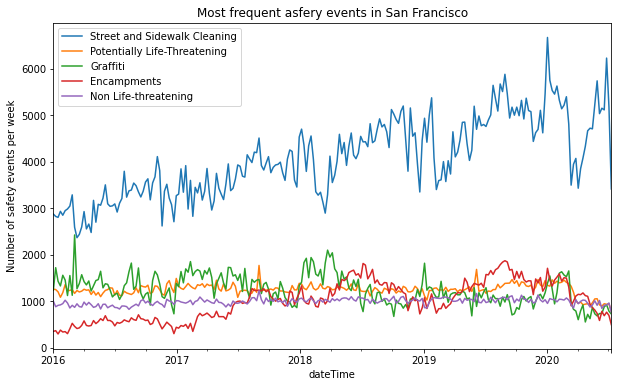

<IPython.core.display.Javascript object>

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for name in categories:
    mask = df["category"] == name
    df[mask].groupby(pd.Grouper(key="dateTime", freq="7D"))["requestId"].count().plot(
        ax=ax, label=name
    )

ax.legend(loc="best")
ax.set_ylabel("Number of safety events per week")
_ = ax.set_title("Most frequent asfery events in San Francisco")

## plot periodicity of events

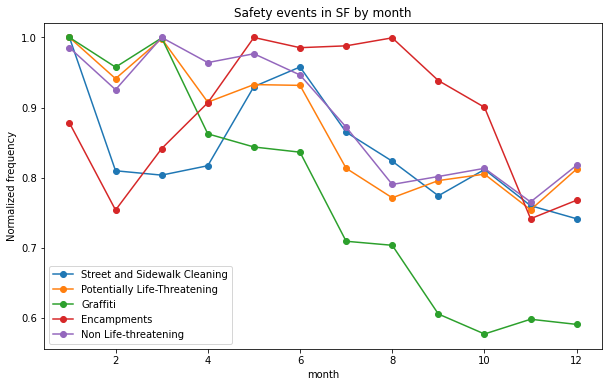

<IPython.core.display.Javascript object>

In [9]:
# Evaluating periodicity of events
def plot_periodicity(df, ax, categories, period="month"):
    for name in categories:
        mask = df["category"] == name
        group = getattr(df["dateTime"].dt, period)
        res = df[mask].groupby(group)["requestId"].count()
        (res / res.max()).plot.line(ax=ax, label=name, marker="o")

    ax.legend(loc="best")
    ax.set_title(f"Safety events in SF by {period}")
    ax.set_xlabel(period)
    ax.set_ylabel("Normalized frequency")


fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_periodicity(df, ax, categories, period="month")

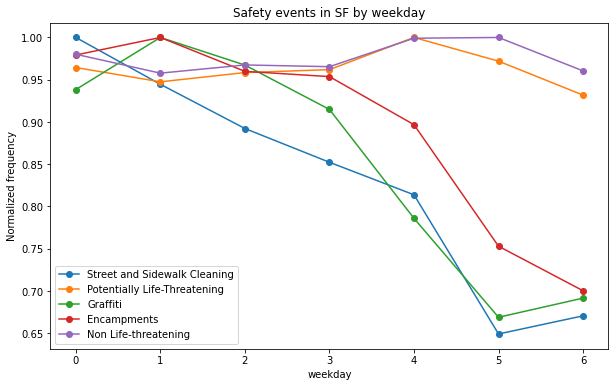

<IPython.core.display.Javascript object>

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_periodicity(df, ax, categories, period="weekday")

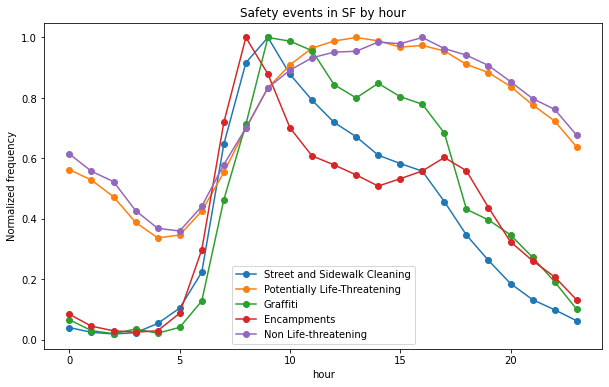

<IPython.core.display.Javascript object>

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_periodicity(df, ax, categories, period="hour")

## Event status statistics

In [12]:
# exploring the interaction of category with other columns in the data

<IPython.core.display.Javascript object>

In [13]:
group_cols = ["requestId", "category", "status"]
mask = df["category"].isin(categories)

# we convert the str to include NaN
df.loc[mask, group_cols].astype("str").groupby(["category", "status"])[
    "requestId"
].count()

category                      status
Encampments                   Closed    238334
                              Open         819
Graffiti                      Closed    294283
                              Open        2453
Street and Sidewalk Cleaning  Closed    963392
                              Open        2037
Name: requestId, dtype: int64

<IPython.core.display.Javascript object>

In [14]:
group_cols = ["requestId", "category", "source"]
mask = df["category"].isin(categories)

df.loc[mask, group_cols].astype("str").groupby(["category", "source"])[
    "requestId"
].count()

category                      source           
Encampments                   Integrated Agency       241
                              Mobile/Open311       177612
                              Other Department         47
                              Phone                 38559
                              Twitter                 820
                              Web                   21874
Graffiti                      Integrated Agency     17593
                              Mobile/Open311       212033
                              Other Department          2
                              Phone                 19041
                              Twitter                 699
                              Web                   47368
Street and Sidewalk Cleaning  Email                     2
                              Integrated Agency     41795
                              Mobile/Open311       567054
                              Other Department         93
                        

<IPython.core.display.Javascript object>

### Geographic distribution of events

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

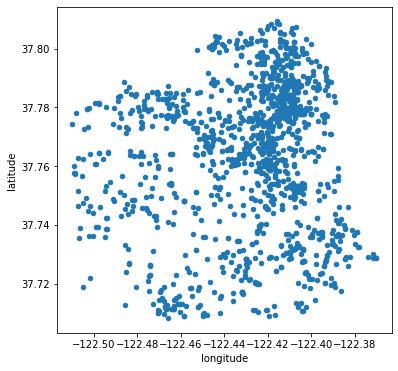

<IPython.core.display.Javascript object>

In [15]:
# Visualize an arbitrary date with a scatter plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

mask = (
    (df["dateTime"] >= pd.to_datetime("2019-01-20"))
    & (df["dateTime"] < pd.to_datetime("2019-01-21"))
    # filter GPS coordinates
    & (df["latitude"] != 0.0)
    & (df["longitude"] != 0.0)
)

df[mask].plot.scatter(y="latitude", x="longitude", ax=ax)

We gonna use py Leafet to a better visualization

In [16]:
dates = ("2019-01-20", "2019-01-21")
category = "Potentially life-threatening"

mask = (
    (df["dateTime"] >= pd.to_datetime(dates[0]))
    & (df["dateTime"] < pd.to_datetime(dates[1]))
    & (df["latitude"] != 0.0)
    & (df["longitude"] != 0.0)
    & (df["category"] == category)
)

# center the map on centroids of events
center = list(df.loc[mask, ["latitude", "longitude"]].median(axis=0))

m = Map(center=center, zoom=11.5)
print(f"Rendering for {dates[0]} - {dates[1]} and category={category}")
markers = [
    Marker(location=(x, y)) for (x, y) in df.loc[mask, ["latitude", "longitude"]].values
]

cl = MarkerCluster(markers=markers)
m.add_layer(cl)

m

Rendering for 2019-01-20 - 2019-01-21 and category=Potentially life-threatening


Map(center=[nan, nan], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

<IPython.core.display.Javascript object>

## Interactive widget

In [17]:
from ipywidgets import Dropdown
from ipyleaflet import WidgetControl

center = list(df[["latitude", "longitude"]].median(axis=0))

dates = ("2019-01-20", "2019-01-21")


def make_markers(df, categories):
    mask = (
        (df["dateTime"] >= pd.to_datetime(dates[0]))
        & (df["dateTime"] < pd.to_datetime(dates[1]))
        & (df["latitude"] != 0.0)
        & (df["longitude"] != 0.0)
        & (df["category"] == category)
    )
    markers = [
        Marker(location=(x, y))
        for (x, y) in df.loc[mask, ["latitude", "longitude"]].values
    ]
    return markers


def make_map(df, center):
    print(f"Rendering map for {dates[0]} - {dates[1]}")
    m = Map(center=center, zoom=11.5)
    markers = make_markers(df, list(categories)[0])

    cl = MarkerCluster(markers=markers)
    m.add_layer(cl)
    return m


m = make_map(df, center)


def on_click(change):
    category_name = change("new")
    old_layer = m.layers[-1]
    markers = maker_markers(df, category_name)
    cl = MarkerCluster(markers=markers)
    m.substitude_layer(old_layer, cl)


dropdown = Dropdown(
    options=list(categories), value=list(categories)[0], description="Category"
)
dropdown.observe(on_click, "value")

basemap_control = WidgetControl(widget=dropdown, position="topright")
m.add_control(basemap_control)

Rendering map for 2019-01-20 - 2019-01-21


<IPython.core.display.Javascript object>

## Compute the city neighborhhod name for each event location

In [18]:
# download the GeoJSON with San francisco neighborhood info
import urllib.request
import json

url = "https://gist.githubusercontent.com/rth/403f672baf26beef91285c8079e1d257/raw/ebe3d2a4eda405775a860d251974e1f08cbe4f48/SanFrancisco.Neighborhoods.json"
with urllib.request.urlopen(url) as response:
    sf_ngh = json.loads(response.read())

<IPython.core.display.Javascript object>

In [19]:
sf_ngh

{'type': 'FeatureCollection',
 'features': [{'geometry': {'geometries': [{'type': 'Polygon',
      'coordinates': [[[-122.391701, 37.794113],
        [-122.39198, 37.793906],
        [-122.391614, 37.793571],
        [-122.391714, 37.793459],
        [-122.388816, 37.791005],
        [-122.388932, 37.790919],
        [-122.388616, 37.790348],
        [-122.388076, 37.790518],
        [-122.388375, 37.790334],
        [-122.388225, 37.790032],
        [-122.385852, 37.790951],
        [-122.385496, 37.790559],
        [-122.387589, 37.789838],
        [-122.387289, 37.789347],
        [-122.385303, 37.789838],
        [-122.38512, 37.789313],
        [-122.387174, 37.788807],
        [-122.387032, 37.788255],
        [-122.385261, 37.788537],
        [-122.385136, 37.788156],
        [-122.38739, 37.787736],
        [-122.387415, 37.787269],
        [-122.3845, 37.787437],
        [-122.384342, 37.785728],
        [-122.387577, 37.785485],
        [-122.38765, 37.784929],
        [-122.

<IPython.core.display.Javascript object>

In [21]:
# count the number of neighborhoods
len(sf_ngh["features"])

23

<IPython.core.display.Javascript object>

In [23]:
# extract the border coordinates for the first neighboord
import numpy as np

neighborhood = sf_ngh["features"][0]

print(neighborhood["properties"]["neighborhood"])
sf_ngh_border = np.array(neighborhood["geometry"]["geometries"][0]["coordinates"][0])
sf_ngh_border[:10]

Rincon Hill


array([[-122.391701,   37.794113],
       [-122.39198 ,   37.793906],
       [-122.391614,   37.793571],
       [-122.391714,   37.793459],
       [-122.388816,   37.791005],
       [-122.388932,   37.790919],
       [-122.388616,   37.790348],
       [-122.388076,   37.790518],
       [-122.388375,   37.790334],
       [-122.388225,   37.790032]])

<IPython.core.display.Javascript object>

In [24]:
# for each GPS coordinates, we need to compute wheter they are inside or outside this plygon
df[["longitude", "latitude"]].head()

,longitude,latitude
0,-122.422187,37.781286
1,-122.418188,37.791887
2,0.000000,0.000000
3,-122.443245,37.802853
4,-122.456498,37.737953


<IPython.core.display.Javascript object>

In [26]:
# we get a boolean mask for each point inside the neighborhood
res = mpl_path.Path(sf_ngh_border).contains_points(df[["longitude", "latitude"]])
res

array([False, False, False, ..., False, False, False])

<IPython.core.display.Javascript object>

In [27]:
res.sum()

64892

<IPython.core.display.Javascript object>

In [29]:
# Loop over the neighborhoods sotred in the GeoJSON and store the result into a new column
df["neighborhood"] = np.full(len(df), np.nan, dtype="object")

for feature in sf_ngh["features"]:
    name = feature["properties"]["neighborhood"]
    print(f"Processing neighborhood: {name}")
    # drop any single dimensional entries from  the shape of the array
    border = np.squeeze(np.array(feature["geometry"]["geometries"][0]["coordinates"]))
    # skip for now but it require a special handling
    if border.ndim != 2:
        print(f"wrong number of dimensions={border.shape}!=2 skipping")
        continue
    mask = mpl_path.Path(border).contains_points(df[["longitude", "latitude"]])
    df.loc[mask, "neighborhood"] = name

Processing neighborhood: Rincon Hill
Processing neighborhood: South Beach
Processing neighborhood: Chinatown
Processing neighborhood: Nob Hill
Processing neighborhood: Ingleside
Processing neighborhood: Castro
Processing neighborhood: Sunset
Processing neighborhood: Bayview
Processing neighborhood: Portola
Processing neighborhood: Lake Merced
Processing neighborhood: Twin Peaks
Processing neighborhood: North Beach
Processing neighborhood: Tenderloin
Processing neighborhood: SoMa
Processing neighborhood: Mission
Processing neighborhood: Financial District
Processing neighborhood: Lower Pacific Heights
Processing neighborhood: Taraval
Processing neighborhood: Panhandle
Processing neighborhood: Inner Richmond
Processing neighborhood: Outer Richmond
wrong number of dimensions=(3,)!=2 skipping
Processing neighborhood: Marina


<ipython-input-29-8e065b48762e>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  border = np.squeeze(np.array(feature["geometry"]["geometries"][0]["coordinates"]))


Processing neighborhood: Bayshore


<IPython.core.display.Javascript object>

In [32]:
# 8% of samples couldn't be determined
df["neighborhood"].isna().sum() / df.shape[0] * 100

8.023160200908814

<IPython.core.display.Javascript object>

In [34]:
# results on a few selected columns
df[["category", "dateTime", "longitude", "latitude", "neighborhood"]].sample(
    5, random_state=2
)

,category,dateTime,longitude,latitude,neighborhood
1823109,Encampments,2019-07-26 06:10:00,-122.405768,37.780850,SoMa
343137,Abandoned Vehicle,2020-02-27 11:59:00,-122.483124,37.759415,Sunset
3404684,Street and Sidewalk Cleaning,2019-02-16 08:33:00,-122.395805,37.786953,Rincon Hill
3252772,General Request - MTA,2016-01-19 12:54:24,-122.396385,37.780895,South Beach
545633,Potentially Life-Threatening,2016-12-17 14:30:42,-122.411933,37.780006,SoMa


<IPython.core.display.Javascript object>

In [35]:
# store the result on disk
df.to_parquet("data/safety-SanFrancisco-2.parquet")

<IPython.core.display.Javascript object>